# SetUp

In [6]:
#기존 충돌 라이브러리 제거
!pip uninstall -y transformers datasets accelerate peft bitsandbytes numpy

# pip 최신화
!pip install --upgrade pip

# 필요한 라이브러리 재설치 (bitsandbytes 제거, 백슬래시 뒤 공백 없음)
!pip install \
numpy==1.26.4 \
transformers==4.39.3 \
datasets==2.18.0 \
accelerate==0.29.3 \
peft==0.10.0

# 설치 확인
import numpy as np
import transformers, datasets, peft

print("numpy        =", np.__version__)
print("transformers =", transformers.__version__)
print("datasets     =", datasets.__version__)
print("peft         =", peft.__version__)


Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
Found existing installation: datasets 2.14.4
Uninstalling datasets-2.14.4:
  Successfully uninstalled datasets-2.14.4
Found existing installation: accelerate 1.7.0
Uninstalling accelerate-1.7.0:
  Successfully uninstalled accelerate-1.7.0
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 188.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 166.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

numpy        = 2.0.2
transformers = 4.52.4
datasets     = 2.14.4
peft         = 0.15.2


In [1]:
import numpy as np
print(np.__version__)  #


1.26.4


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터 로딩

In [3]:
import pandas as pd

# 파일 경로 설정
train_path = "/content/drive/MyDrive/Colab Notebooks/LORA/imdb_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/LORA/imdb_test.csv"
# data_path = "/content/drive/MyDrive/Colab Notebooks/LORA/data.csv"

# 데이터 로딩
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
# data = pd.read_csv(data_path)

# 데이터 크기 출력
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (40000, 2)
Test shape: (10000, 2)


# 2. Tokenizer 적용

In [4]:
from transformers import AutoTokenizer
from datasets import Dataset

# 🔹 토크나이저 불러오기
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 🔹 토크나이저 함수 정의
def tokenize_function(example):
    return tokenizer(example["sentences"], truncation=True, padding="max_length", max_length=256)

# 🔹 pandas → Huggingface Dataset 변환
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

# 🔹 Tokenize 적용
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 🔹 Trainer를 위한 포맷 지정
train_dataset = train_dataset.rename_column("labels", "label")
test_dataset = test_dataset.rename_column("labels", "label")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# 3. FULL - FT

In [9]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [10]:
# 🔹 Full Fine-tuning
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np
import time
import torch

# 평가 지표
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# 모델 로딩
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# 훈련 설정
training_args_ft = TrainingArguments(
    output_dir="./results_ft",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_steps=20,
    logging_dir="./logs",
    report_to="none",
    fp16=True
)

# 훈련 및 시간 측정
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

trainer_ft = Trainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_ft.train()

end_time = time.time()

# 결과 저장
ft_time = end_time - start_time
metrics_ft = trainer_ft.evaluate()
gpu_mem_ft = torch.cuda.max_memory_allocated() / (1024 ** 2)

print("🔹 Full Fine-tuning 결과")
print("평가 결과:", metrics_ft)
print(f"소요 시간: {ft_time:.2f}초")
#최대순간 GPU
print(f"GPU 사용량: {gpu_mem_ft:.2f}MB")


/usr/local/lib/python3.11/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,0.207300,0.215008,0.917200
2,0.176800,0.258756,0.920900
3,0.048900,0.369101,0.922100


🔹 Full Fine-tuning 결과
평가 결과: {'eval_loss': 0.3691011667251587, 'eval_accuracy': 0.9221, 'eval_runtime': 5.0065, 'eval_samples_per_second': 1997.414, 'eval_steps_per_second': 31.359, 'epoch': 3.0}
소요 시간: 269.31초
GPU 사용량: 3340.60MB


In [11]:
gpu_mem_ft = torch.cuda.max_memory_allocated() / (1024**2)  # MB 단위


# 4. LORA

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [13]:
# 🔹 LoRA Fine-tuning
from peft import get_peft_model, LoraConfig, TaskType

# Pretrained 모델 불러오기
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# LoRA 설정
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# LoRA 모델 적용
model_lora = get_peft_model(base_model, lora_config)

# 훈련 설정
training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_steps=20,
    logging_dir="./logs",
    report_to="none",
    fp16=True
)

# 훈련 및 시간 측정
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_lora.train()

end_time = time.time()

# 결과 저장
lora_time = end_time - start_time
metrics_lora = trainer_lora.evaluate()
gpu_mem_lora = torch.cuda.max_memory_allocated() / (1024 ** 2)

print("🔹 LoRA Fine-tuning 결과")
print("평가 결과:", metrics_lora)
print(f"소요 시간: {lora_time:.2f}초")
#최대순간 GPU
print(f"GPU 사용량: {gpu_mem_lora:.2f}MB")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_co

Epoch,Training Loss,Validation Loss,Accuracy
1,0.244700,0.269643,0.889800
2,0.296300,0.255658,0.897400
3,0.225200,0.253455,0.898900


🔹 LoRA Fine-tuning 결과
평가 결과: {'eval_loss': 0.2534545660018921, 'eval_accuracy': 0.8989, 'eval_runtime': 5.4147, 'eval_samples_per_second': 1846.822, 'eval_steps_per_second': 28.995, 'epoch': 3.0}
소요 시간: 264.73초
GPU 사용량: 2587.83MB


In [16]:
gpu_mem_lora = torch.cuda.max_memory_allocated() / (1024**2)  # MB 단위


# 5 성능 비교

In [15]:
from tabulate import tabulate

def format_time(seconds):
    minutes = int(seconds) // 60
    secs = seconds % 60
    return f"{minutes}분 {secs:.2f}초"

# 안전하게 키 조회
acc_ft = metrics_ft.get("eval_accuracy", metrics_ft.get("accuracy", 0.0))
acc_lora = metrics_lora.get("eval_accuracy", metrics_lora.get("accuracy", 0.0))

# 결과 정리
comparison_table = [
    ["항목", "Full Fine-tuning", "LoRA Fine-tuning"],
    ["훈련 시간", format_time(ft_time), format_time(lora_time)],
    ["정확도 (Accuracy)", f"{acc_ft:.4f}", f"{acc_lora:.4f}"],
    ["GPU 메모리 사용량 (MB)", f"{gpu_mem_ft:.2f}", f"{gpu_mem_lora:.2f}"]
]

# 출력
print("Fine-tuning 성능 비교 결과:")
print(tabulate(comparison_table[1:], headers=comparison_table[0], tablefmt="grid"))


Fine-tuning 성능 비교 결과:
+------------------------+--------------------+--------------------+
| 항목                   | Full Fine-tuning   | LoRA Fine-tuning   |
+========================+====================+====================+
| 훈련 시간              | 4분 29.31초        | 4분 24.73초        |
+------------------------+--------------------+--------------------+
| 정확도 (Accuracy)      | 0.9221             | 0.8989             |
+------------------------+--------------------+--------------------+
| GPU 메모리 사용량 (MB) | 3340.60            | 2587.83            |
+------------------------+--------------------+--------------------+


In [25]:
import matplotlib.pyplot as plt
import warnings
# 경고 메시지 제거
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

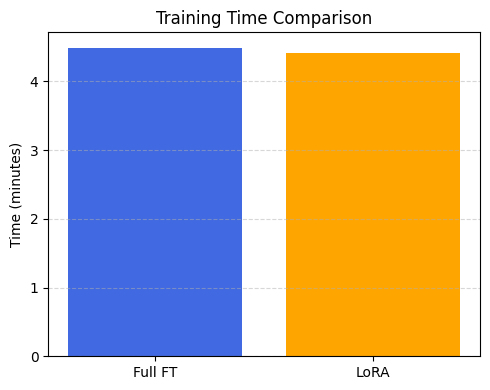

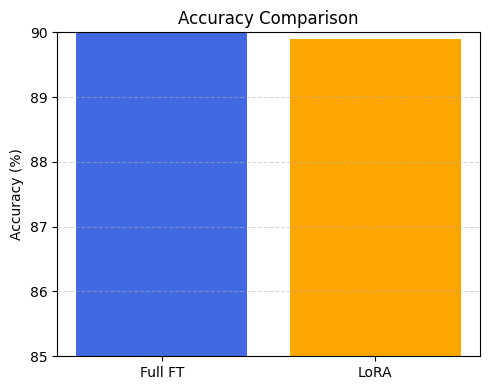

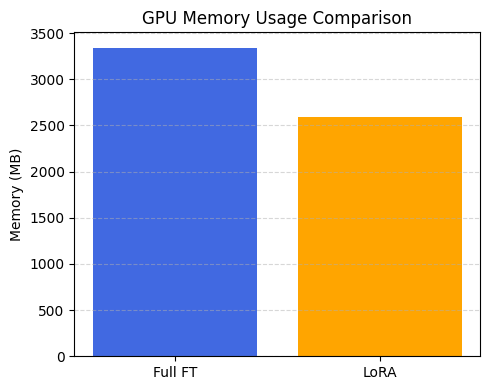

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 불필요한 한글 폰트 지정 제거
mpl.rcParams['font.family'] = 'DejaVu Sans'  # Colab 기본 안전 폰트
mpl.rcParams['axes.unicode_minus'] = False




# 1. Training Time (minutes)
plt.figure(figsize=(5, 4))
plt.bar(["Full FT", "LoRA"], [ft_time / 60, lora_time / 60], color=["royalblue", "orange"])
plt.ylabel("Time (minutes)")
plt.title("Training Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Accuracy
plt.figure(figsize=(5, 4))
plt.bar(["Full FT", "LoRA"], [acc_ft * 100, acc_lora * 100], color=["royalblue", "orange"])
plt.ylabel("Accuracy (%)")
plt.ylim(85, 90)  # 확대해서 차이 강조
plt.title("Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. GPU Memory Usage
plt.figure(figsize=(5, 4))
plt.bar(["Full FT", "LoRA"], [gpu_mem_ft, gpu_mem_lora], color=["royalblue", "orange"])
plt.ylabel("Memory (MB)")
plt.title("GPU Memory Usage Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
